In [1]:
#Pandas, Numpy and misc
import nltk
import pandas as pd
import numpy as np
import re, spacy

#Plottig Tools
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

#Clustering Algorithims
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering

#NLTK 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

#SKlearn
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import MDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


#SCIPY
from scipy.cluster.hierarchy import ward, dendrogram
import scipy.cluster.hierarchy as sch

#gensim
from gensim.test.utils import common_corpus, common_dictionary
from gensim.test.utils import datapath
import gensim
from gensim import corpora, models
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
#We have 2 sets of data, test and train train sets have 
data_train = pd.read_csv('train.csv') 
data_test = pd.read_csv('test.csv')

In [14]:
data_train[['text', 'label_name']].head(50)

,text,label_name
0,reconstructing subject specific effect mapspre...,Computing
1,rotation invariance neural networkrotation inv...,Computing
2,spherical polyharmonics poisson kernels polyha...,Mathematics
3,finite element approximation stochastic maxwel...,Mathematics
4,comparative study discrete wavelet transforms ...,Statistics
5,maximizing fundamental frequency complement ob...,Mathematics
6,rotation period shape hyperbolic asteroid `oum...,Physics
7,adverse effects polymer coating heat transport...,Physics
8,sph calculations mars scale collisions role eq...,Physics
9,\mathcal r _ fails predict outbreak potential ...,Biology


In [5]:
for i in ['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']:
  count=0
  for x in data_train[i]:
    if x == 1:
      count +=1
  print(count)    

8594
6013
5618
5206
587
249


In [6]:
#Data Exploration and some preperation
print("data_train_shape: " , data_train.shape)
print("data_test_shape: " , data_test.shape)
print("------------------")
data_train.info()
print("------------------")
data_test.info()
print("------------------")
data_train.head()
print("------------------")
data_train.ABSTRACT = [" ".join(i.split()) for i in data_train.ABSTRACT]
data_test.ABSTRACT = [" ".join(i.split()) for i in data_test.ABSTRACT]
#Combining the title and abstract titles into a single text column
data_train["text"] = data_train["TITLE"] + data_train["ABSTRACT"]
data_test["text"] = data_test["TITLE"] + data_test["ABSTRACT"]
labels = data_train.columns[3:-1].tolist()
print(labels)
print("------------------")

data_train['label'] = data_train[labels].values.tolist()

le = LabelEncoder()
#Creating Named columns to be used later
data_train.loc[data_train['Computer Science'] == 1, 'label_name'] = "Computing"
data_train.loc[data_train['Physics'] == 1, 'label_name'] = "Physics"
data_train.loc[data_train['Mathematics'] == 1, 'label_name'] = "Mathematics"
data_train.loc[data_train['Statistics'] == 1, 'label_name'] = "Statistics"
data_train.loc[data_train['Quantitative Biology'] == 1, 'label_name'] = "Biology"
data_train.loc[data_train['Quantitative Finance'] == 1, 'label_name'] = "Finance"
#Using Label Encoder to transform the data
data_train['label'] = le.fit_transform(data_train['label'].astype(str))
data_train = data_train[["text","label","label_name"]]

data_test = data_test[["text"]]
data_train=data_train.dropna()

data_train_shape:  (20972, 9)
data_test_shape:  (8989, 3)
------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20972 entries, 0 to 20971
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID                    20972 non-null  int64 
 1   TITLE                 20972 non-null  object
 2   ABSTRACT              20972 non-null  object
 3   Computer Science      20972 non-null  int64 
 4   Physics               20972 non-null  int64 
 5   Mathematics           20972 non-null  int64 
 6   Statistics            20972 non-null  int64 
 7   Quantitative Biology  20972 non-null  int64 
 8   Quantitative Finance  20972 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 1.4+ MB
------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8989 entries, 0 to 8988
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID       

In [ ]:
data_train[['text', 'label_name']]

,text,label_name
0,reconstructing subject specific effect mapspre...,Computing
1,rotation invariance neural networkrotation inv...,Computing
2,spherical polyharmonics poisson kernels polyha...,Mathematics
3,finite element approximation stochastic maxwel...,Mathematics
4,comparative study discrete wavelet transforms ...,Statistics
...,...,...
20967,contemporary machine learning guide practition...,Physics
20968,uniform diamond coatings wc co hard alloy cutt...,Physics
20969,analysing soccer games clustering conceptorswe...,Computing
20970,efficient simulation left tail sum correlated ...,Statistics


In [7]:
nltk.download('stopwords')
stemmer = PorterStemmer()

def pre_processing(data):
  data['text']=data['text'].str.replace('\$','')
  data['text']=data['text'].str.replace('$','')
  data['text']=[" ".join(i.split()) for i in data.text]


   #This removes unwanted characters
  data['text'] = [re.sub(r'[0-9]','',i) for i in data.text]
  data['text'] = [re.sub(r'[/(){}\[\]\|@,;.:-]',' ',i) for i in data.text]
  data['text'] = [i.lower() for i in data.text]

  data['text']=data['text'].str.replace('  ',' ')
  
  #Remove Stop words
  #Import stopwords with nltk.
    
  stop = stopwords.words('english')

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
#Stemming the words 
  data["text"] = data["text"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
  data['text'] = data['text'].apply(stemmer.stem)
  
  return data


data_train = pre_processing(data_train)
data_test = pre_processing(data_test)



  
    

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


In [8]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)

def vectorize_tfidf(data):
  vec = TfidfVectorizer(stop_words="english", ngram_range=(1, 3))
  vec.fit(data)
  features=vec.transform(data)
  return features
data_train_vec = vectorize_tfidf(data_train['text'])
data_test_vec = vectorize_tfidf(data_test['text'])    

In [ ]:
data_train_vec

<20972x3063366 sparse matrix of type '<class 'numpy.float64'>'
	with 5091359 stored elements in Compressed Sparse Row format>

# Determining optimal K using elbow method

In [ ]:

Sum_of_squared_distances = []
K = range(1,6)
for k in K:
   km = KMeans(n_clusters=k, max_iter=100, n_init=10)
   km = km.fit(data_train_vec)
   Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [11]:
#
clust = MiniBatchKMeans(init='k-means++', n_clusters = 4, n_init=10, max_iter=200)
clust.fit(data_train_vec)
pred = clust.predict(data_train_vec)
data_train['cluster_labels'] = clust.labels_

In [12]:
print(data_train['cluster_labels'].unique())
print(data_train['label_name'].unique())
data_train[['label_name','cluster_labels' ]].tail(15)
math = []
comp = []
phys = []
fina = []
biol = []
stats = []
for i in range(len(data_train)):

  if data_train['label_name'][i] == "Mathematics":
    math.append(data_train['cluster_labels'][i])
  elif data_train['label_name'][i] == "Computing":
    comp.append(data_train['cluster_labels'][i])
  elif data_train['label_name'][i] == "Physics":
    phys.append(data_train['cluster_labels'][i])    
  elif data_train['label_name'][i] == "Finance":
    fina.append(data_train['cluster_labels'][i])
  elif data_train['label_name'][i] == "Biology":
    biol.append(data_train['cluster_labels'][i])    
  elif data_train['label_name'][i] == "Statistics":
    stats.append(data_train['cluster_labels'][i])
    
for x in [math, comp, fina, stats, phys, biol]:
  total = 0
  print("__________________")
  if x == math:
     (print("Maths")) 
  elif x == comp: 
    (print("Comp"))
  elif x == fina: 
    (print("Finance"))
  elif x == stats: 
    (print("Statistics"))
  elif x == phys: 
    (print("Physics"))
  elif x == biol: 
    (print("Biology"))

  for i in set(x):
    print(str(i) + ": " + str(x.count(i)) )
    total += x.count(i)
  print(total)  



[0 2 1 3]
['Computing' 'Mathematics' 'Statistics' 'Physics' 'Biology' 'Finance']
__________________
Maths
0: 211
1: 3675
2: 15
3: 703
4604
__________________
Comp
0: 2204
1: 913
2: 904
3: 889
4910
__________________
Finance
0: 89
1: 47
2: 8
3: 105
249
__________________
Statistics
0: 2824
1: 850
2: 1193
3: 202
5069
__________________
Physics
0: 323
1: 139
2: 108
3: 4987
5557
__________________
Biology
0: 172
1: 17
2: 100
3: 294
583


In [ ]:
#Getting unique labels
testPred = clust.fit_predict(data_test_vec[0:100])

print(testPred)

array([5, 5, 2, 4, 2, 4, 4, 4, 2, 3, 2, 0, 0, 3, 0, 5, 0, 2, 0, 2, 2, 0,
       3, 4, 0, 5, 3, 1, 4, 4, 5, 2, 1, 4, 5, 2, 2, 1, 0, 3, 4, 3, 5, 2,
       1, 1, 0, 2, 3, 3, 5, 2, 1, 5, 0, 2, 2, 1, 4, 4, 5, 3, 0, 1, 2, 3,
       2, 2, 2, 5, 2, 0, 2, 2, 4, 5, 1, 4, 4, 0, 1, 3, 1, 0, 2, 5, 0, 0,
       2, 5, 0, 4, 2, 4, 2, 5, 3, 4, 4, 0], dtype=int32)

Failed graph Attempt:

In [ ]:
data_train_vec

<20972x3063366 sparse matrix of type '<class 'numpy.float64'>'
	with 5091359 stored elements in Compressed Sparse Row format>

In [ ]:
u_labels = np.unique(testPred)
 
for i in u_labels:
    plt.scatter(data_train_vec[testPred == i , 0] , data_train_vec[testPred == i , 1] , label = i)
plt.legend()
plt.show()

# Agglomerative Clustering

Agglomerative Clustering is a method of heirarichal clustering, the algorithm starts by placing every element into a cluster of its own and continues merging them into more general clusters in a recursive manner

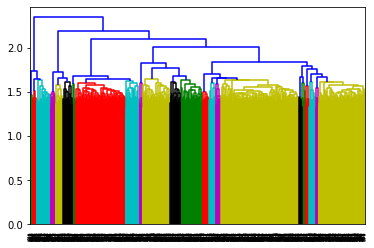

In [ ]:
dist = 1 - cosine_similarity(data_test_vec[0:1000])

#X.toarray()
clustering = AgglomerativeClustering().fit(dist)
dendrogram = sch.dendrogram(sch.linkage(dist, method='ward'), truncate_mode='level')

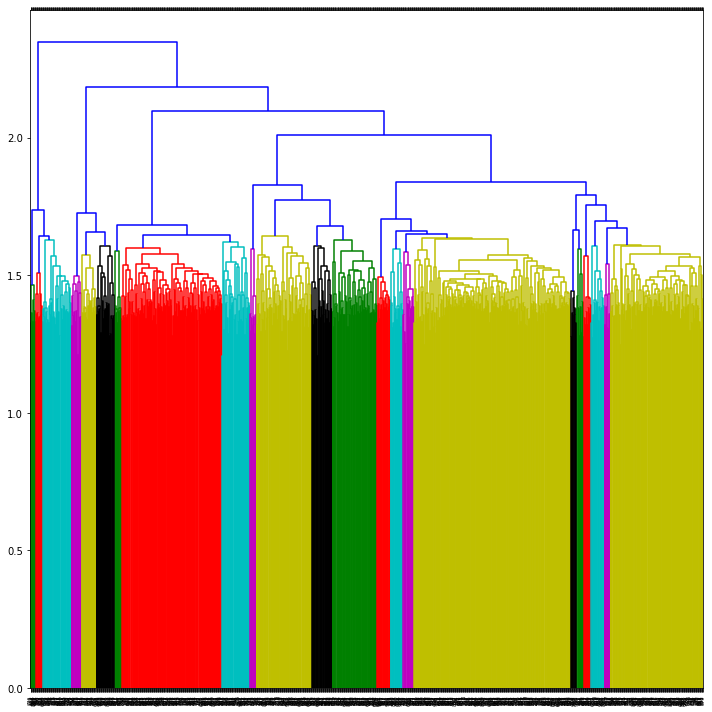

In [ ]:
linkage_matrix = ward(dist)

fig, ax = plt.subplots(figsize=(10, 10)) # set size
ax = sch.dendrogram(linkage_matrix);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout


# LDA

In [18]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

processed_docs = data_train['text'].map(preprocess)

2252

In [19]:
dictionary = gensim.corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=.020, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]


lda_model_tfidf = gensim.models.LdaMulticore(bow_corpus, num_topics=4, id2word=dictionary, passes=1, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.010*"network" + 0.010*"model" + 0.008*"method" + 0.007*"use" + 0.006*"base" + 0.006*"show" + 0.006*"result" + 0.006*"estim" + 0.005*"propos" + 0.005*"gener"
Topic: 1 Word: 0.011*"model" + 0.006*"result" + 0.006*"learn" + 0.006*"show" + 0.006*"studi" + 0.005*"problem" + 0.005*"use" + 0.005*"algorithm" + 0.005*"base" + 0.005*"gener"
Topic: 2 Word: 0.010*"use" + 0.007*"data" + 0.006*"method" + 0.005*"propos" + 0.005*"show" + 0.005*"system" + 0.005*"gener" + 0.005*"result" + 0.005*"learn" + 0.005*"model"
Topic: 3 Word: 0.014*"model" + 0.009*"data" + 0.007*"time" + 0.007*"use" + 0.006*"gener" + 0.005*"problem" + 0.005*"show" + 0.005*"system" + 0.005*"base" + 0.005*"algorithm"
